<h1><center>Stack</center></h1>
<h2><center> Classificação de imagens com Fashon-MNIST em Pytorch</center></h2>

Vamos utilizar um dataset muito famoso chamado Fashion-MNIST. A idéia é prever qual classe uma determinada imagem pertence, dentre os 10 tipos de roupas do dataset.


<center><img src="fashion/fashion_mnist_dataset.png"/></center>


<center><img src="fashion/classes.png"/></center>


<center><img src="fashion/diagram.png"/></center>

In [35]:
import numpy as np
import matplotlib.pyplot as plt


In [36]:
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.optim as optim
#import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader


* **torch.optim**

    * conta com alguns algoritmos de otimização como SGD e Adam.

* **torch.nn.functional** 

    * Funções de ativação não lineares  ( relu, softmax, logsigmoid ... )

* **torchvision** 

    * conjunto de dados
    * Arquitetura de modelos
    * Transformações de imagem  ( comuns para visão computacional )
    * Vamos usar o dataset MNIST e fazer algumas transformações nas imagens utilizando Composition

* **Subset RandomSampler**

    *  Usada para dividir o conjunto de dados em subconjuntos de treinamento e validação para validação 

> # Importando os dados

In [37]:
from torchvision import datasets, transforms

# Define a as transforçaões que serão aplicadas nos dados - transforma os dados em tonsores e os normaliza
    # média e desvio padrão são tuplas
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5, ), (0.5,))])

In [38]:
# Download dados de treino e teste
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=transform)


# Criar o loader dos dados
train_loader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)  

In [39]:
print("train data: ", len(train_loader))
print("test data: ", len(test_loader))

train data:  938
test data:  157


.

In [40]:
# Examinar os dados
dataiter = iter(train_loader)
images, labels = dataiter.next()

print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([64, 1, 28, 28])
torch.Size([64])


.

* **transforms.Compose**
    * Cria as series de transformações que serão aplicadas aos dados
* **transform.Normalize**
    * Normaliza a imagem com uma determinada média e desvio padrão
* **torch.utils.data.Dataloader**
    * Faz o load dos nossos dados de teste e treino com os parametros de batch_size definidos e shuffle para embaralhar os dados

    

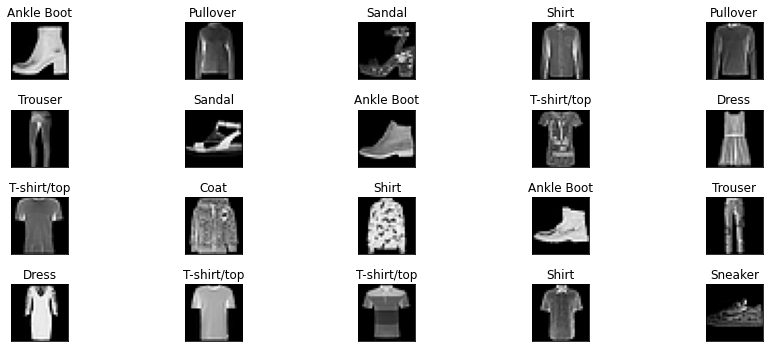

In [41]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize = (15,5))
rows = 4 
columns = 5 


fashion_classes = { 0 : 'T-shirt/top' ,
                    1 : 'Trouser',
                    2 : 'Pullover',
                    3 : 'Dress',
                    4 :'Coat',
                    5 : 'Sandal',
                    6 : 'Shirt',
                    7 : 'Sneaker',
                    8 : 'Bag',
                    9 : 'Ankle Boot'}


for idx in np.arange(20):
    ax = fig.add_subplot(rows  , columns , idx + 1, xticks = [], yticks = [])
    ax.imshow(images[idx].numpy().squeeze(), cmap ='gray')
    ax.set_title( fashion_classes[labels[idx].item()] )
    fig.tight_layout()

> # O modelo


<center><img src="fashion/network.png"/></center>

* **nn.Module**
    * Constrói as redes neurais.
* **super().__init__()**
    * Cria uma nossa arquiterura com metodos e atributos da classe nn.module
    

* 784 entradas e 256 saídas para a primeira camada oculta e o atribui a self.fc1.
* 256 entradas e 128 saídas
* 128 entradas e 64 saídas

* Foward:
    * Tensor x como input e muda o shape para considerar o batch
    * Imagens passam pela rede
    * Dados passam pela função Log Softmax para obter as probabilidades de log na rede neural.

In [42]:
from torch import nn, optim
import torch.nn.functional as F

class Modelo(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 =  nn.Linear(784,256)
        self.fc2 =  nn.Linear(256,128)
        self.fc3 =  nn.Linear(128,64)
        self.fc4 =  nn.Linear(64,10)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1) ## flattening o Tensor
        
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.log_softmax(self.fc4(x), dim = 1)
        
        return x

* **Durante a fase de treino**:
    * Instanciamos nosso modelo
        * De acordo com a arquitetura que criamos 
    * Define o critério de avaliação de performance
        * Negative log-likelihood
    * Define o otimizador (SGD)
    * Drfine as epocas de treinamento 
    * Guarda os valores de loss tanto do treino qnt  de validação para avaliação do modelo
    * Define modelo para formato de treinamento - modl.train()
    * Vamos fazer um loop sobre o trainloader que possui as imagens e os labels 
        * Esses serão os dados usados para alimentar a rede

In [43]:
model = Modelo()

# Definido a função LOSS e o otimizador
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01) 

* Transforma cada entrada em valores entre 0 e 1 e os normaliza para lhes dar uma distribuição de probabilidade adequada onde as probabilidades somam-se a 1.
    *  [**softmax function**](https://en.wikipedia.org/wiki/Softmax_function)

\begin{align}
\sigma(x_i) = \frac{e^{x_i}} {\sum_k^K{e^{x_k}}}
\end{align}


<center><img src="logSoftMax.png"/></center>

* **model = Modelo()** 
    * Instancia o modelo
* **zero_grad**:
    * Limpa os valores de gradientes de forma que não os acumule
* **log_probs**:
    * Probabilidades em log do resuldado ao passarmos as imágens pelo nossa rede neural
* **loss**:
    * Calcula o valor de loss de acordo com nosso critério pré-definido
* **loss.backward()**:
    * Realiza o backward pass para calcular os gradientes dos parametros do modelo
* **optimizer.step()**:
    * Realiza o otimização dos parametros do modelo conforme otimizador pré-definido

In [44]:
min_validation_loss = np.inf
epochs = 15

# Preparar nosso modelo para treinar
model.train()
train_loss_list, validation_loss_list = [], []


for epoch in range(epochs):
    model.train()
    running_loss = 0
    validation_loss = 0
    
    # Treinando o modelo
    for images, labels in train_loader:
        # Treino
        optimizer.zero_grad()
        log_probs = model(images)
        loss = criterion(log_probs, labels)
        loss.backward()
        optimizer.step() # Att pesos
        running_loss += loss.item()*images.size(0)
        #running_loss += loss.item()
      
    model.eval()
    with torch.no_grad():
        total =0
        correct = 0
        for images, labels in test_loader:
            log_probs = model(images)
            loss = criterion(log_probs, labels)
            validation_loss += loss.item()*images.size(0)
            #validation_loss += loss.item()
            max_class = torch.argmax(log_probs, dim = 1)
            total += labels.numel()
            correct += sum(max_class == labels).item()
            
        print("Acurácia de Teste: {:.2f}%".format(correct / total * 100))

    running_loss = running_loss / len(train_loader.sampler)
    validation_loss = validation_loss / len(test_loader.sampler)
    
    train_loss_list.append(running_loss)
    validation_loss_list.append(validation_loss)
    
    print("Epoch: {}/{}:".format(epoch+1, epochs),
          "Loss Treino: {:.6f}..".format(running_loss),
          "Loss Validação: {:.6f}..".format(validation_loss))
         
    if validation_loss <= min_validation_loss:
        print('Validation loss anterior {} --> Validation loss novo {}. Salvando modelo.'.format(min_validation_loss, validation_loss))
        torch.save(model.state_dict(), 'modelo.pth')
        min_validation_loss = validation_loss
        
    print()

Acurácia de Teste: 73.60%
Epoch: 1/15: Loss Treino: 1.365027.. Loss Validação: 0.718751..
Validation loss anterior inf --> Validation loss novo 0.7187511287689209. Salvando modelo.

Acurácia de Teste: 77.55%
Epoch: 2/15: Loss Treino: 0.617185.. Loss Validação: 0.602400..
Validation loss anterior 0.7187511287689209 --> Validation loss novo 0.6023997885227204. Salvando modelo.

Acurácia de Teste: 81.32%
Epoch: 3/15: Loss Treino: 0.522136.. Loss Validação: 0.523565..
Validation loss anterior 0.6023997885227204 --> Validation loss novo 0.5235653522491455. Salvando modelo.

Acurácia de Teste: 82.25%
Epoch: 4/15: Loss Treino: 0.474292.. Loss Validação: 0.489287..
Validation loss anterior 0.5235653522491455 --> Validation loss novo 0.4892865739822388. Salvando modelo.

Acurácia de Teste: 83.41%
Epoch: 5/15: Loss Treino: 0.443406.. Loss Validação: 0.460548..
Validation loss anterior 0.4892865739822388 --> Validation loss novo 0.46054772090911866. Salvando modelo.

Acurácia de Teste: 83.55%
Epo

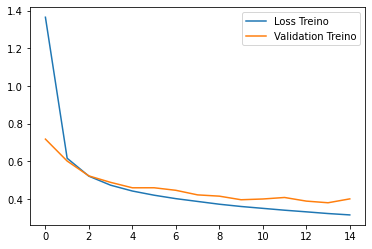

In [45]:
plt.plot(train_loss_list, label = 'Loss Treino')
plt.plot(validation_loss_list, label = 'Validation Treino')
plt.legend()

.


<center><img src="fashion/model_complexity_error_training_test.jpg"/></center>


# Verificando resultado

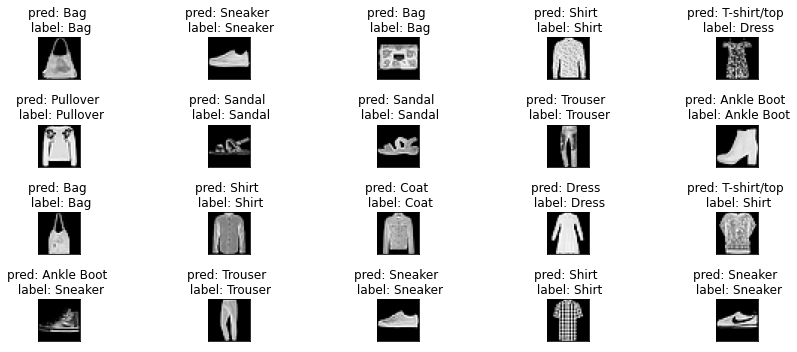

In [50]:
# 1 batch
dataiter = iter(test_loader)
images, labels = dataiter.next()
output = model(images)


fig = plt.figure(figsize = (15,5))
rows = 4 
columns = 5 


_ , predictions = torch.max(output, 1)
images = images.numpy()

for idx in np.arange(20):
    ax = fig.add_subplot(rows  , columns , idx + 1, xticks = [], yticks = [])
    ax.imshow(np.squeeze(images[idx]), cmap ='gray')
    ax.set_title('pred: {} \n label: {}'.format(fashion_classes[predictions[idx].item()] , fashion_classes[labels[idx].item() ]))
    fig.tight_layout()